# <font color='black'>Deep Neural Networks</font>

---
<figure>
<center>
<img src='https://drive.google.com/uc?id=1u-iZKwzco1L8a3gFFLMXbSOU_DsdNZqo' width="300" align="center" />
</center>
</figure>


> Year: **2022**

> Version: **1.1**

# Face recognition system

In this exercise, we will study a face recognition system.

Notably the algorithm will learn a neural network that encodes a face image into a vector of 128 numbers. By comparing two such encoded vectors, you can then decide if two pictures are of the same person.
    
* In this exercise, we will be using a pre-trained model which represents ConvNet activations using **"channels first"** convention, as opposed to the "channels last" convention. Therefore, a batch of images will be of shape $(m, n_C, n_H, n_W)$ instead of $(m, n_H, n_W, n_C)$.

## Set up
We start by loading the required packages.

In [27]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/MyDrive/Colab_Notebooks/Ma511/Lab2/TP2/') # The location of the .ipynb file.
#This is necessary to import fr_utils and inception_blocks_v2.
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers import Concatenate
from keras.layers import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
#from keras.engine.topology import Layer
#from keras.utils.layer_utils import get_source_inputs
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from fr_utils import *
from inception_blocks_v2 import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Face Verification

In Face Verification problems, you're given two images and the task consists on determining if they are of the same person. We will learn an encoding, $f(img)$ for each image. In order to determine whether two pictures are of the same persone we will compare the corresponding encodings.

We will load the weights from an already trained neural network that follows the Inception architecture. Let's start by create the model that we will use:

- The network uses 96x96 dimensional RGB images as input. Specifically, inputs a face image (or batch of $m$ face images) as a tensor of shape $(m, n_C, n_H, n_W) = (m, 3, 96, 96)$
- It outputs a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector.

In [28]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

Instructions for updating:
Colocations handled automatically by placer.


In [29]:
print("Total Params:", FRmodel.count_params())

Total Params: 3743280


Or Total Params: 220032

Using a 128-neuron fully connected layer as its last layer, the output of the model is an encoding vector of size 128. Then, computing the distance between two encodings and thresholding, you can determine if the two pictures represent the same person.

An encoding suitable solution if:
- The encodings of two images of the same person are  similar to each other.
- The encodings of two images of different persons are  different.





### The Triplet Loss

In order to train the network to learn useful encodings. We will use the triple loss function. This approach tries to create encodings similars for the same perone (Anchor and Postive)and differents for images of different persons (Anchor and Negative).


For an image $x$, we denote its encoding $f(x)$, where $f$ is the function computed by the neural network.
Training will use triplets of images $(A, P, N)$:  

- A is an "Anchor" image--a picture of a person.
- P is a "Positive" image--a picture of the same person as the Anchor image.
- N is a "Negative" image--a picture of a different person than the Anchor image.

These triplets are picked from our training dataset. We will write $(A^{(i)}, P^{(i)}, N^{(i)})$ to denote the $i$-th training example.


We would thus like to minimize the following "triplet cost":

$$J = \sum^{m}_{i=1} \large[ \small {\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2} - {\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2} + \alpha \large ] \small_+ $$


We will now implement the triplet loss as defined by formula above.

* Some Uueful functions: `tf.reduce_sum()`, `tf.square()`, `tf.subtract()`, `tf.add()`, `tf.maximum()`.

* Remark  that the `anchor`, `positive` and `negative` encodings are of shape `(m,128)`, where m is the number of training examples and 128 is the number of elements used to encode a single example.

In [30]:
def triplet_loss(y_true, y_pred, alpha=0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    ### START CODE HERE ###
    # Step 1: Compute the (encoding) distance between the anchor and the positive, sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)

    # Step 2: Compute the (encoding) distance between the anchor and the negative, sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)

    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)

    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    ### END CODE HERE ###

    return loss


In [31]:
import tensorflow.compat.v1 as tf

with tf.Session() as test:
    tf.set_random_seed(1)
    y_true = (None, None, None)
    y_pred = (tf.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
              tf.random_normal([3, 128], mean=1, stddev=1, seed = 1),
              tf.random_normal([3, 128], mean=3, stddev=4, seed = 1))
    loss = triplet_loss(y_true, y_pred)

    print("loss = " + str(loss.eval()))

loss = 528.1426



<table>
    <tr>
        <td>
            **loss**
        </td>
        <td>
           528.143
        </td>
    </tr>

</table>

### Loading the pre-trained model

Since training requires a lot of data and a lot of computation, we won't train it from zero. Instead, we load a previously trained model.

In [36]:
#This takes more than a minute. Please be patient.
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

### Face Verification

Let's fist build the encoding vector for each person in the database. In order to generate the encoding we use `img_to_encoding(image_path, model)`, which runs the forward propagation of the model on the specified image.


In [42]:
pa="/content/gdrive/MyDrive/Colab_Notebooks/Ma511/Lab2/TP2/TP2/"
database = {}
database["danielle"] = img_to_encoding(pa+"images/danielle.png", FRmodel)
database["younes"] = img_to_encoding(pa+"images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding(pa+"images/tian.jpg", FRmodel)
database["kian"] = img_to_encoding(pa+"images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding(pa+"images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding(pa+"images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding(pa+"images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding(pa+"images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding(pa+"images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding(pa+"images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding(pa+"images/arnaud.jpg", FRmodel)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [43]:
#Visualizing the database.
for (name, db_enc) in database.items():
  print(name, db_enc.shape)

danielle (1, 128)
younes (1, 128)
tian (1, 128)
kian (1, 128)
dan (1, 128)
sebastiano (1, 128)
bertrand (1, 128)
kevin (1, 128)
felix (1, 128)
benoit (1, 128)
arnaud (1, 128)


We will now implement the `verify()` function which checks if `image_path` is actually the person called "identity". In order to implement it we will,
1. Compute the encoding of the image from `image_path`.
2. Compute the distance between this encoding and the encoding of the identity image stored in the database.
3. Open the door if the distance is less than 0.7, else do not open it.

* `identity` is a string that is also a key in the `database` dictionary.
* `img_to_encoding` has two parameters: the `image_path` and `model`. This function is defined at line 192 of fr_utils.py.

In [49]:
def verify(image_path, identity, database, model):


    # Step 1: Compute the encoding for the image. Use img_to_encoding().
    encoding = img_to_encoding(image_path, model)

    # Step 2: Compute distance with identity's image
    dist = np.linalg.norm(encoding - database[identity])

    # Step 3: Open the door if dist < 0.7, else don't open
    door_open = dist < 0.7

    if door_open:
        print("It's " + str(identity) + ", welcome home!")
    else:
        print("It's not " + str(identity) + ", please go away")

    return dist, door_open


In [58]:
verify(pa+"images/camera_0.jpg", "danielle", database, FRmodel)

It's not danielle, please go away


(1.2107373, False)

It's not kian, please go away


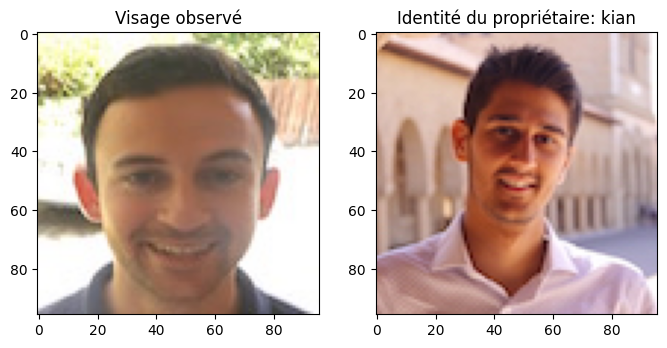

In [65]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image_path_to_verify = pa + "images/camera_0.jpg"
claimed_identity = "kian"


dist, door_open = verify(image_path_to_verify, claimed_identity, database, FRmodel)

# Display the images
img_original = mpimg.imread(image_path_to_verify)
img_claimed_identity = mpimg.imread(pa + f"images/{claimed_identity}.jpg")

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_original)
plt.title("Visage observé")

plt.subplot(1, 2, 2)
plt.imshow(img_claimed_identity)
plt.title(f"Identité du propriétaire: {claimed_identity}")

plt.show()


### Face Recognition

We will now implement a face recognition system. This way, no one has to carry an ID card anymore. An authorized person can just walk up to the building, and the door will unlock for them.

The face recognition system inputs an image, and figures out if it is one of the authorized persons and who is it.

We will implement in the following cell `who_is_it()`:
1. Compute the encoding of the image from image_path
2. Find the encoding from the database that has smallest distance with the target encoding.
    - Initialize the `min_dist` variable to a large enough number (100). It will help you keep track of what is the closest encoding to the input's encoding.
    - Loop over the database dictionary's names and encodings.
    - Compute the L2 distance between the input "encoding" and the current "encoding" from the database.
    - If this distance is less than the min_dist, then set `min_dist` to `dist`, and `identity` to `name`.

In [53]:
def who_is_it(image_path, database, model):

    ### START CODE HERE ###

    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding(). ##
    encoding = img_to_encoding(image_path, model)

    ## Step 2: Find the closest encoding ##

    # On initilise la distance à une valeur grande
    min_dist = 100

    # On passe par tout les viasgaes du dictionnaire
    for name, db_enc in database.items():

        dist = np.linalg.norm(encoding - db_enc)


        if dist < min_dist: # Si la distance est plus petite que la distance minimale l'identité est reconnue
            min_dist = dist
            identity = name

    ### END CODE HERE ###

    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print("It's " + str(identity) + ", the distance is " + str(min_dist))

    return min_dist, identity


Let's see if your who_it_is() algorithm identifies Younes.

In [67]:
who_is_it(pa+"images/camera_2.jpg", database, FRmodel)

It's benoit, the distance is 0.22837466


(0.22837466, 'benoit')

It's dan, the distance is 0.25603133


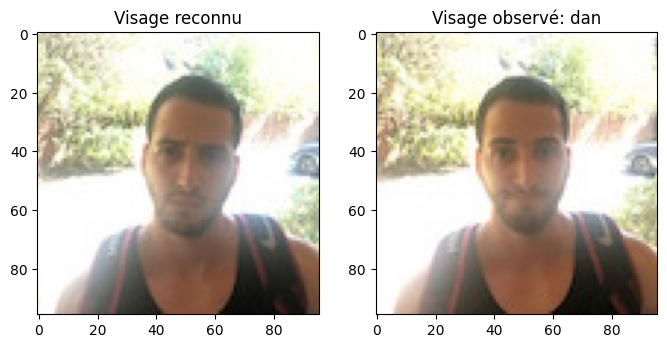

In [82]:
image_path_to_verify = pa + "images/camera_4.jpg"
dist, claimed_identity = who_is_it(image_path_to_verify, database, FRmodel)


img_observée = mpimg.imread(image_path_to_verify)
img_claimed_identity = mpimg.imread(pa + f"images/{claimed_identity}.jpg")

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_observée)
plt.title(f"Visage reconnu")

plt.subplot(1, 2, 2)
plt.imshow(img_claimed_identity)
plt.title(f"Visage observé: {claimed_identity}")

plt.show()



Other variations that will help improving the Face
Verification system:

- Put more images of each person (under different lighting conditions, taken on different days, etc.) into the database. Then given a new image, compare the new face to multiple pictures of the person. This would increase accuracy.

- Crop the images to just contain the face, and less of the "border" region around the face. This preprocessing removes some of the irrelevant pixels around the face, and also makes the algorithm more robust.


### References:

- Florian Schroff, Dmitry Kalenichenko, James Philbin (2015). [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf)
- Yaniv Taigman, Ming Yang, Marc'Aurelio Ranzato, Lior Wolf (2014). [DeepFace: Closing the gap to human-level performance in face verification](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf)
- Victor Sy Wang's implementation was loaded using this code: https://github.com/iwantooxxoox/Keras-OpenFace.
- The implementation also took a lot of inspiration from
https://github.com/gemaatienza/Deep-Learning-Coursera/blob/master/4.%20Convolutional%20Neural%20Networks/Face%20Recognition%20for%20the%20Happy%20House%20-%20v3.ipynb and
the official FaceNet github repository: https://github.com/davidsandberg/facenet
